### Demo of instructor training applied to the dual dynamics

Here we train the learning signals producing the support states.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from disp import set_plot, colors

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 2.6.0+cu124
Cuda available: False
Device: cpu


In [2]:
torch.manual_seed(1337)

# model params
D = 2
N = 2000
TAU = .01
G = 100
DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

def get_z(x):
    return 1*x

def psi_fn(z):
    return (1+torch.tanh(J_psi@z))*np.sqrt(2/N)

def ker(x_1, x_2):
    return psi_fn(x_1)@psi_fn(x_2)

def advance(x, z, alphas, x_stars, u, L_nz, ml, iss):
    # get next x
    temp = torch.zeros((D, 1))
    for alpha, x_star in zip(alphas[:-1], x_stars[:-1]):  # final alpha, x_star just place holder
        temp += alpha.reshape((D, 1))*ker(x.reshape((D,)), x_star.reshape((D,)))
    x_next = x + DT/TAU*(-x + C@temp + B@u)

    # update support states
    L = L_nz*ml
    alphas_next = [alpha.clone() for alpha in alphas]
    alphas_next[iss] = L.clone()
    x_stars_next = [x_star.clone() for x_star in x_stars]
    x_stars_next[iss] = x_next.clone()
    
    return x_next, alphas_next, x_stars_next

In [3]:
# smln params
T = 1.6
IT = int(round(T/DT))
t = np.arange(IT)*DT

# initial conditions
N_SS = 2  ## num support states
x_0 = torch.tensor([[.001, .001]], device=device).T
alphas_0 = [torch.zeros((D,), device=device) for _ in range(N_SS+1)]  # final alpha just placeholder
x_stars_0 = [torch.zeros((D,), device=device) for _ in range(N_SS+1)]  # final x_star just placeholder

# inputs
us = torch.zeros((IT, D), device=device)
us[20, 0] = -.05/DT
us[820, 0] = .05/DT

In [4]:
# mask for nonzero learning signals
IT_L_NZ = torch.tensor([25, 825], device=device)
IT_L_NZ_2 = -1*torch.ones((IT,), dtype=int)
IT_L_NZ_2[IT_L_NZ] = torch.arange(2, dtype=int)

ML = torch.zeros((IT, D), device=device)
ML[IT_L_NZ, :] = 1

In [5]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[[160, 960], 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

In [6]:
lr = .01
nepoch = 20

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])
    
L_nz = ML.clone().detach()*0
L_nz.requires_grad = True

losses = []
L_nz_save = []
z_hats_save = []

for epoch in range(nepoch):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]
    alphas_all = [[alpha.clone() for alpha in alphas_0]]
    x_stars_all = [[x_star.clone() for x_star in x_stars_0]]

    for ct in range(1, IT):
        x_hat_next, alphas_next, x_stars_next = advance(x_hats[-1], z_hats[-1], alphas_all[-1], x_stars_all[-1], us[[ct], :].T, L_nz[[ct], :].T, ML[[ct], :].T, IT_L_NZ_2[ct])
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)
        alphas_all.append(alphas_next)
        x_stars_all.append(x_stars_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        L_nz -= lr*L_nz.grad
        L_nz.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == nepoch):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        L_nz_save.append(L_nz.clone().detach().numpy())

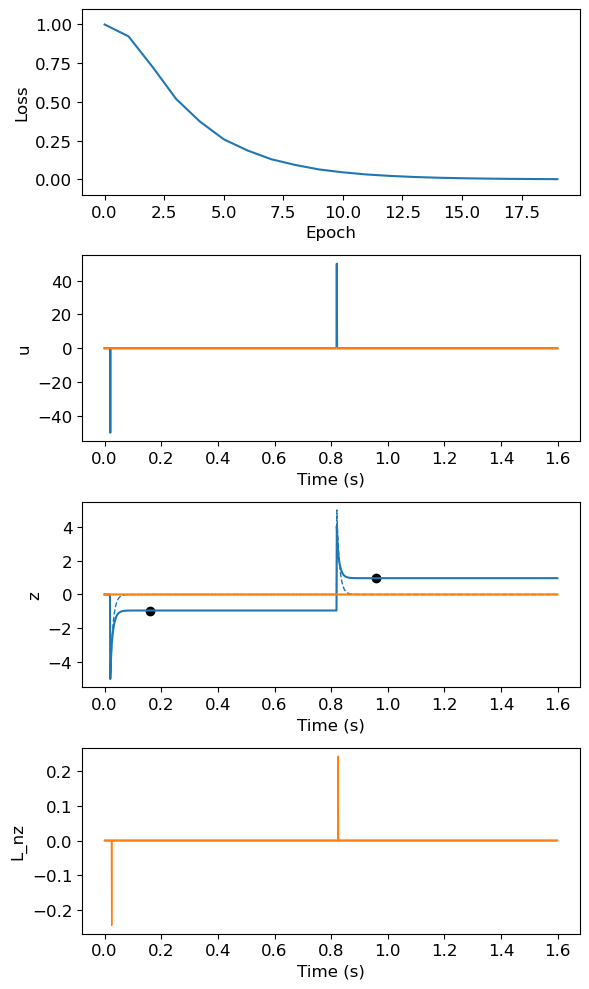

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10), tight_layout=True)

axs[0].plot(range(nepoch), losses)
set_plot(axs[0], y_lim=(-.1, 1.1), x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='z')

for L_nz, c in zip(L_nz_save, colors):
    axs[3].plot(t, L_nz, c=c, lw=1)
set_plot(axs[3], x_label='Time (s)', y_label='L_nz')

Longer delay

In [8]:
# smln params
T = 1.6
IT = int(round(T/DT))
t = np.arange(IT)*DT

# initial conditions
N_SS = 2  ## num support states
x_0 = torch.tensor([[.001, .001]], device=device).T
alphas_0 = [torch.zeros((D,), device=device) for _ in range(N_SS+1)]
x_stars_0 = [torch.zeros((D,), device=device) for _ in range(N_SS+1)]

# inputs
us = torch.zeros((IT, D), device=device)
us[20, 0] = -.05/DT
us[820, 0] = .05/DT

In [9]:
# mask for nonzero learning signals
IT_L_NZ = torch.tensor([25, 825], device=device)
IT_L_NZ_2 = -1*torch.ones((IT,), dtype=int)
IT_L_NZ_2[IT_L_NZ] = torch.arange(2, dtype=int)

ML = torch.zeros((IT, D), device=device)
ML[IT_L_NZ, :] = 1

In [10]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[[760, 1560], 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

In [11]:
lr = .01
nepoch = 20

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])
    
L_nz = ML.clone().detach()*0
L_nz.requires_grad = True

losses = []
L_nz_save = []
z_hats_save = []

for epoch in range(nepoch):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]
    alphas_all = [[alpha.clone() for alpha in alphas_0]]
    x_stars_all = [[x_star.clone() for x_star in x_stars_0]]

    for ct in range(1, IT):
        x_hat_next, alphas_next, x_stars_next = advance(x_hats[-1], z_hats[-1], alphas_all[-1], x_stars_all[-1], us[[ct], :].T, L_nz[[ct], :].T, ML[[ct], :].T, IT_L_NZ_2[ct])
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)
        alphas_all.append(alphas_next)
        x_stars_all.append(x_stars_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        L_nz -= lr*L_nz.grad
        L_nz.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == nepoch):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        L_nz_save.append(L_nz.clone().detach().numpy())

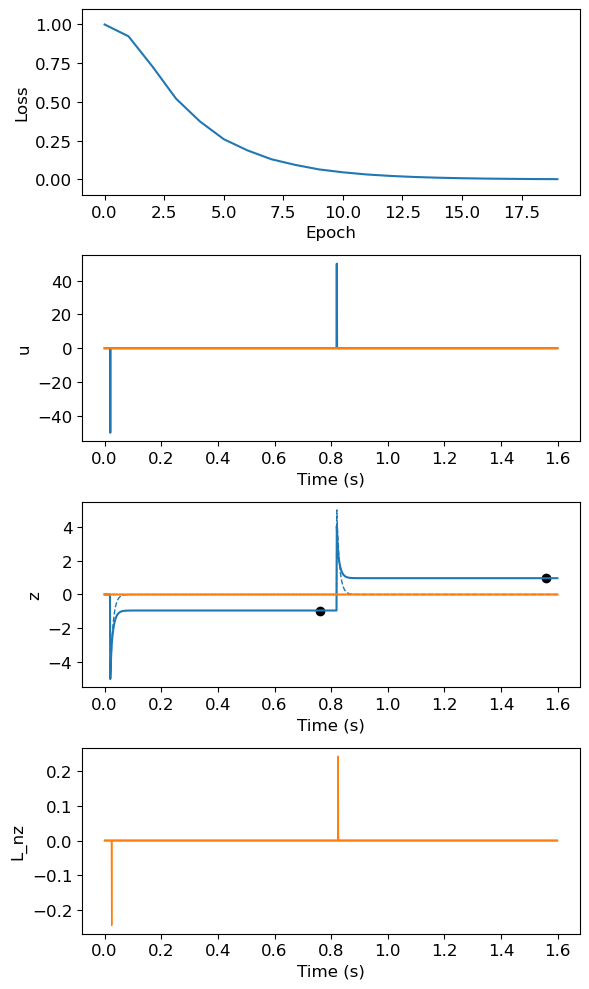

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10), tight_layout=True)

axs[0].plot(range(nepoch), losses)
set_plot(axs[0], y_lim=(-.1, 1.1), x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='z')

for L_nz, c in zip(L_nz_save, colors):
    axs[3].plot(t, L_nz, c=c, lw=1)
set_plot(axs[3], x_label='Time (s)', y_label='L_nz')